# Предсказание расходов на электричество, воду и тепло
Решение построено на статье https://forecastegy.com/posts/multiple-time-series-forecasting-with-deepar-in-python/ 

In [1]:
#!pip install pytorch-lightning

In [2]:
#!pip install "gluonts[torch]"

In [2]:
#!pip install --upgrade mxnet gluonts

In [9]:
#!pip install openpyxl

## Подготовка данных

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [5]:
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [16]:
df = pd.read_excel('train_data/all_expenses.xlsx')

In [20]:
df2 = df.drop(df[df['Unnamed: 0'].str.contains('Итого') == True].index)
df2.drop('Unnamed: 0', axis= 1 , inplace= True )

In [25]:
df2['Наименование вида расходов'].value_counts()

Наименование вида расходов
Расходы на коммунальные услуги                                                                      6347
Оплата водоснабжения, канализации                                                                   3581
Оплата потребления электроэнергии                                                                   3035
Оплата потребления тепловой энергии                                                                 1746
Оплата услуг водоснабжения, водоотведения                                                           1367
Расходы по оплате услуг водоснабжения, водоотведения                                                1233
Расходы по оплате потребления электроэнергии                                                         719
Расходы по оплате всех видов отопления зданий и сооружений (кроме электро- и газового снабжения)     582
Оплата всех видов отопления зданий и сооружений (кроме электро- и газового снабжения)                547
Оплата потребления газа     

In [27]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19190 entries, 1 to 21412
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Adress                      19190 non-null  object 
 1   Год сметы                   19190 non-null  int64  
 2   Смета                       19190 non-null  object 
 3   Подразделение БР            19190 non-null  object 
 4   Код статьи                  19190 non-null  float64
 5   Код вида расходов           19190 non-null  object 
 6   Наименование вида расходов  19190 non-null  object 
 7   Направление расходов        19190 non-null  object 
 8   Начальный остаток           0 non-null      float64
 9   Отнесено                    19190 non-null  float64
 10  Конечный остаток            19190 non-null  float64
 11  Дата проведения             19190 non-null  object 
dtypes: float64(4), int64(1), object(7)
memory usage: 1.9+ MB


In [30]:
pd.unique(df[['Код вида расходов', 'Наименование вида расходов']].values.ravel())

array(['132.0111.000000', 'Оплата потребления электроэнергии',
       '132.0113.000000', 'Оплата водоснабжения, канализации',
       '132.0112.000000', 'Оплата потребления тепловой энергии',
       '134.1100.000000', 'Расходы на коммунальные услуги',
       '134.1100.010000', 'Расходы по оплате потребления электроэнергии',
       '134.1100.020000',
       'Расходы по оплате всех видов отопления зданий и сооружений (кроме электро- и газового снабжения)',
       '134.1100.030000',
       'Расходы по оплате услуг водоснабжения, водоотведения',
       '134.1000.030000', 'Оплата услуг водоснабжения, водоотведения',
       '134.1000.010000', '134.1000.020000',
       'Оплата всех видов отопления зданий и сооружений (кроме электро- и газового снабжения)',
       '134.1000.040000', 'Оплата потребления газа', '134.1000.050000',
       'Коммунальные услуги (расходы прошлых лет)', '134.1100.040000',
       'Расходы по оплате потребления газа'], dtype=object)

'132.0111.000000', 'Оплата потребления электроэнергии',
'134.1100.010000', 'Расходы по оплате потребления электроэнергии',
'134.1000.010000', 'Оплата потребления электроэнергии', 

'132.0113.000000', 'Оплата водоснабжения, канализации',
'134.1000.030000', 'Оплата услуг водоснабжения, водоотведения',
'134.1100.030000', 'Расходы по оплате услуг водоснабжения, водоотведения',

'132.0112.000000', 'Оплата потребления тепловой энергии',
'134.1100.020000', 'Расходы по оплате всех видов отопления зданий и сооружений (кроме электро- и газового снабжения)',
'134.1000.020000', 'Оплата всех видов отопления зданий и сооружений (кроме электро- и газового снабжения)',

'134.1000.040000', 'Оплата потребления газа', 
'134.1100.040000', 'Расходы по оплате потребления газа'
'134.1100.000000', 'Расходы на коммунальные услуги',
'134.1000.050000', 'Коммунальные услуги (расходы прошлых лет)', 

In [35]:
df3 = df2[df2['Код вида расходов'] == '134.1100.000000']
df3

,Adress,Год сметы,Смета,Подразделение БР,Код статьи,Код вида расходов,Наименование вида расходов,Направление расходов,Начальный остаток,Отнесено,Конечный остаток,Дата проведения
493,"г. Анадырь, ул. Горького 7",2018,Хозяйственно-эксплуатационное направление Чукотка,Отделение по Чукотскому автономному округу Дал...,134.11,134.1100.000000,Расходы на коммунальные услуги,Оплата за электроэнергию по тарифам зд. г. Ана...,NaN,90818.46,90818.46,06.02.2018
494,"г. Анадырь, ул. Горького 7",2018,Хозяйственно-эксплуатационное направление Чукотка,Отделение по Чукотскому автономному округу Дал...,134.11,134.1100.000000,Расходы на коммунальные услуги,Оплата за электроэнергию по тарифам зд. г. Ана...,NaN,90453.14,90453.14,05.03.2018
495,"г. Анадырь, ул. Горького 7",2018,Хозяйственно-эксплуатационное направление Чукотка,Отделение по Чукотскому автономному округу Дал...,134.11,134.1100.000000,Расходы на коммунальные услуги,Оплата за электроэнергию по тарифам зд. г. Ана...,NaN,88419.29,88419.29,04.04.2018
496,"г. Анадырь, ул. Горького 7",2018,Хозяйственно-эксплуатационное направление Чукотка,Отделение по Чукотскому автономному округу Дал...,134.11,134.1100.000000,Расходы на коммунальные услуги,Оплата за электроэнергию по тарифам зд. г. Ана...,NaN,80235.75,80235.75,04.05.2018
497,"г. Анадырь, ул. Горького 7",2018,Хозяйственно-эксплуатационное направление Чукотка,Дальневосточное главное управление Центральног...,134.11,134.1100.000000,Расходы на коммунальные услуги,Оплата за электроэнергию по тарифам зд. г. Ана...,NaN,64394.96,64394.96,05.06.2018
...,...,...,...,...,...,...,...,...,...,...,...,...
21363,"ул.Фонтанная,19",2019,Хозяйственно-эксплуатационное направление ДГУ,Дальневосточное главное управление Центральног...,134.11,134.1100.000000,Расходы на коммунальные услуги,Оплата за электроэнергию по тарифам зд. Скла...,NaN,1810.06,1810.06,20.08.2019
21364,"ул.Фонтанная,19",2019,Хозяйственно-эксплуатационное направление ДГУ,Дальневосточное главное управление Центральног...,134.11,134.1100.000000,Расходы на коммунальные услуги,Оплата за электроэнергию по тарифам зд. Скла...,NaN,3279.23,3279.23,18.09.2019
21365,"ул.Фонтанная,19",2019,Хозяйственно-эксплуатационное направление ДГУ,Дальневосточное главное управление Центральног...,134.11,134.1100.000000,Расходы на коммунальные услуги,Оплата за электроэнергию по тарифам зд. Скла...,NaN,1469.65,1469.65,21.10.2019
21366,"ул.Фонтанная,19",2019,Хозяйственно-эксплуатационное направление ДГУ,Дальневосточное главное управление Центральног...,134.11,134.1100.000000,Расходы на коммунальные услуги,Оплата за электроэнергию по тарифам зд. Скла...,NaN,2138.36,2138.36,21.11.2019


In [36]:
## Заводим колонку "Энергоэффективность"
def get_type_efficiency(row):
    if row['Код вида расходов'] == '132.0111.000000':
        return 'Электричество'
    if row['Код вида расходов'] == '134.1100.010000':
        return 'Электричество'
    if row['Код вида расходов'] == '134.1000.010000':
        return 'Электричество'

    if row['Код вида расходов'] == '132.0113.000000':
        return 'Вода'
    if row['Код вида расходов'] == '134.1000.030000':
        return 'Вода'
    if row['Код вида расходов'] == '134.1100.030000':
        return 'Вода'

    if row['Код вида расходов'] == '132.0112.000000':
        return 'Тепло'
    if row['Код вида расходов'] == '134.1100.020000':
        return 'Тепло'
    if row['Код вида расходов'] == '134.1000.020000':
        return 'Тепло'

    return 'Коммуналка'

df2['Тип энергоэффективности'] = df2.apply(get_type_efficiency, axis=1)
df2

,Adress,Год сметы,Смета,Подразделение БР,Код статьи,Код вида расходов,Наименование вида расходов,Направление расходов,Начальный остаток,Отнесено,Конечный остаток,Дата проведения,Тип энергоэффективности
1,(гараж),2016,Смета РКЦ Советская Гавань Отделения по Хабаро...,Дальневосточное главное управление Центральног...,132.0111,132.0111.000000,Оплата потребления электроэнергии,Расходы прошлого года.Оплата потребления элект...,NaN,232.93,232.93,28.01.2016,Электричество
3,(Гараж).,2016,Смета РКЦ Советская Гавань Отделения по Хабаро...,Дальневосточное главное управление Центральног...,132.0111,132.0111.000000,Оплата потребления электроэнергии,Оплата потребления электроэнергии (Гараж). ст....,NaN,204.30,204.30,20.02.2016,Электричество
4,(Гараж).,2016,Смета РКЦ Советская Гавань Отделения по Хабаро...,Дальневосточное главное управление Центральног...,132.0111,132.0111.000000,Оплата потребления электроэнергии,Оплата потребления электроэнергии (Гараж). ст....,NaN,245.53,245.53,24.03.2016,Электричество
5,(Гараж).,2016,Смета РКЦ Советская Гавань Отделения по Хабаро...,Дальневосточное главное управление Центральног...,132.0111,132.0111.000000,Оплата потребления электроэнергии,Оплата потребления электроэнергии (Гараж). ст....,NaN,365.77,365.77,20.05.2016,Электричество
6,(Гараж).,2016,Смета РКЦ Советская Гавань Отделения по Хабаро...,Дальневосточное главное управление Центральног...,132.0111,132.0111.000000,Оплата потребления электроэнергии,Оплата потребления электроэнергии (Гараж). ст....,NaN,-28.59,-28.59,31.05.2016,Электричество
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21407,"ул.Энергетиков, 40",2016,Смета Аппарата Отделения по Чукотскому автоном...,Дальневосточное главное управление Центральног...,132.0111,132.0111.000000,Оплата потребления электроэнергии,Другие расходы.Оплата потребления электроэнерг...,NaN,50.57,50.57,05.08.2016,Электричество
21408,"ул.Энергетиков, 40",2016,Смета Аппарата Отделения по Чукотскому автоном...,Дальневосточное главное управление Центральног...,132.0111,132.0111.000000,Оплата потребления электроэнергии,Другие расходы.Оплата потребления электроэнерг...,NaN,25.29,25.29,07.09.2016,Электричество
21409,"ул.Энергетиков, 40",2016,Смета Аппарата Отделения по Чукотскому автоном...,Дальневосточное главное управление Центральног...,132.0111,132.0111.000000,Оплата потребления электроэнергии,Другие расходы.Оплата потребления электроэнерг...,NaN,37.94,37.94,06.10.2016,Электричество
21410,"ул.Энергетиков, 40",2016,Смета Аппарата Отделения по Чукотскому автоном...,Дальневосточное главное управление Центральног...,132.0111,132.0111.000000,Оплата потребления электроэнергии,Другие расходы.Оплата потребления электроэнерг...,NaN,37.94,37.94,07.11.2016,Электричество


In [41]:
def get_first_day_month(value):
    vl = value.split('.')
    year = int(vl[2])
    month = int(vl[1])
    return pd.Timestamp(f'{year}-{month}-01')
    
df2['Месяц платежа'] = df2['Дата проведения'].map(get_first_day_month)
df2

,Adress,Год сметы,Смета,Подразделение БР,Код статьи,Код вида расходов,Наименование вида расходов,Направление расходов,Начальный остаток,Отнесено,Конечный остаток,Дата проведения,Тип энергоэффективности,Месяц платежа
1,(гараж),2016,Смета РКЦ Советская Гавань Отделения по Хабаро...,Дальневосточное главное управление Центральног...,132.0111,132.0111.000000,Оплата потребления электроэнергии,Расходы прошлого года.Оплата потребления элект...,NaN,232.93,232.93,28.01.2016,Электричество,2016-01-01
3,(Гараж).,2016,Смета РКЦ Советская Гавань Отделения по Хабаро...,Дальневосточное главное управление Центральног...,132.0111,132.0111.000000,Оплата потребления электроэнергии,Оплата потребления электроэнергии (Гараж). ст....,NaN,204.30,204.30,20.02.2016,Электричество,2016-02-01
4,(Гараж).,2016,Смета РКЦ Советская Гавань Отделения по Хабаро...,Дальневосточное главное управление Центральног...,132.0111,132.0111.000000,Оплата потребления электроэнергии,Оплата потребления электроэнергии (Гараж). ст....,NaN,245.53,245.53,24.03.2016,Электричество,2016-03-01
5,(Гараж).,2016,Смета РКЦ Советская Гавань Отделения по Хабаро...,Дальневосточное главное управление Центральног...,132.0111,132.0111.000000,Оплата потребления электроэнергии,Оплата потребления электроэнергии (Гараж). ст....,NaN,365.77,365.77,20.05.2016,Электричество,2016-05-01
6,(Гараж).,2016,Смета РКЦ Советская Гавань Отделения по Хабаро...,Дальневосточное главное управление Центральног...,132.0111,132.0111.000000,Оплата потребления электроэнергии,Оплата потребления электроэнергии (Гараж). ст....,NaN,-28.59,-28.59,31.05.2016,Электричество,2016-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21407,"ул.Энергетиков, 40",2016,Смета Аппарата Отделения по Чукотскому автоном...,Дальневосточное главное управление Центральног...,132.0111,132.0111.000000,Оплата потребления электроэнергии,Другие расходы.Оплата потребления электроэнерг...,NaN,50.57,50.57,05.08.2016,Электричество,2016-08-01
21408,"ул.Энергетиков, 40",2016,Смета Аппарата Отделения по Чукотскому автоном...,Дальневосточное главное управление Центральног...,132.0111,132.0111.000000,Оплата потребления электроэнергии,Другие расходы.Оплата потребления электроэнерг...,NaN,25.29,25.29,07.09.2016,Электричество,2016-09-01
21409,"ул.Энергетиков, 40",2016,Смета Аппарата Отделения по Чукотскому автоном...,Дальневосточное главное управление Центральног...,132.0111,132.0111.000000,Оплата потребления электроэнергии,Другие расходы.Оплата потребления электроэнерг...,NaN,37.94,37.94,06.10.2016,Электричество,2016-10-01
21410,"ул.Энергетиков, 40",2016,Смета Аппарата Отделения по Чукотскому автоном...,Дальневосточное главное управление Центральног...,132.0111,132.0111.000000,Оплата потребления электроэнергии,Другие расходы.Оплата потребления электроэнерг...,NaN,37.94,37.94,07.11.2016,Электричество,2016-11-01


In [44]:
df2 = df2[['Adress', 'Конечный остаток', 'Тип энергоэффективности', 'Месяц платежа']]
df2 

,Adress,Конечный остаток,Тип энергоэффективности,Месяц платежа
1,(гараж),232.93,Электричество,2016-01-01
3,(Гараж).,204.30,Электричество,2016-02-01
4,(Гараж).,245.53,Электричество,2016-03-01
5,(Гараж).,365.77,Электричество,2016-05-01
6,(Гараж).,-28.59,Электричество,2016-05-01
...,...,...,...,...
21407,"ул.Энергетиков, 40",50.57,Электричество,2016-08-01
21408,"ул.Энергетиков, 40",25.29,Электричество,2016-09-01
21409,"ул.Энергетиков, 40",37.94,Электричество,2016-10-01
21410,"ул.Энергетиков, 40",37.94,Электричество,2016-11-01


In [47]:
df2

,Adress,Тип энергоэффективности,Месяц платежа,Конечный остаток
,,,,sum
0,(Гараж).,Электричество,2016-02-01,204.30
1,(Гараж).,Электричество,2016-03-01,245.53
2,(Гараж).,Электричество,2016-05-01,337.18
3,(Гараж).,Электричество,2016-06-01,347.58
4,(Гараж).,Электричество,2016-07-01,299.88
...,...,...,...,...
11232,"ул.Энергетиков, 40",Электричество,2016-08-01,50.57
11233,"ул.Энергетиков, 40",Электричество,2016-09-01,25.29
11234,"ул.Энергетиков, 40",Электричество,2016-10-01,37.94


In [49]:
#df2 = df2.groupby(['Adress', 'Тип энергоэффективности', 'Месяц платежа']).agg({'Конечный остаток': ['sum']}).reset_index()
df2.columns = ['Adress', 'Тип энергоэффективности', 'Месяц платежа', 'Сумма платежа']
df2

,Adress,Тип энергоэффективности,Месяц платежа,Сумма платежа
0,(Гараж).,Электричество,2016-02-01,204.30
1,(Гараж).,Электричество,2016-03-01,245.53
2,(Гараж).,Электричество,2016-05-01,337.18
3,(Гараж).,Электричество,2016-06-01,347.58
4,(Гараж).,Электричество,2016-07-01,299.88
...,...,...,...,...
11232,"ул.Энергетиков, 40",Электричество,2016-08-01,50.57
11233,"ул.Энергетиков, 40",Электричество,2016-09-01,25.29
11234,"ул.Энергетиков, 40",Электричество,2016-10-01,37.94
11235,"ул.Энергетиков, 40",Электричество,2016-11-01,37.94


In [50]:
# Находим количество разных месяцев 
df2['Месяц платежа'].value_counts()

Месяц платежа
2016-03-01    251
2016-06-01    251
2016-12-01    247
2016-02-01    247
2016-11-01    246
             ... 
2019-07-01    108
2019-11-01    106
2019-09-01    104
2019-01-01     97
2022-01-01     91
Name: count, Length: 73, dtype: int64

In [ ]:
# Находим те адреса, по которым были платежи в 2021 году

In [68]:
df3 = df2.loc[df2['Месяц платежа'] > '2021-12-01']
adress_list = df3['Adress'].unique()
adress_list

array(['г. Анадырь, ул. Дежнева 7', 'г. Анадырь, ул. Дежнева, 7',
       'г. Анадырь, ул. Дежнева, 7 дизель-генераторная установка',
       'г. Анадырь, ул. Колхозная 32 Б (склад)',
       'г. Анадырь, ул. Южная 1а', 'г. Анадырь, ул. Южная, 1а (гараж)',
       'г. Билибино',
       'г. Благовещенск, пер. Святителя Иннокентия, 17, Административное зд. (Пристройка)',
       'г. Благовещенск, пер. Святителя Иннокентия, 17, Административное здание',
       'г. Благовещенск, пер. Святителя Иннокентия, 17, Гараж',
       'г. Благовещенск, пер. Святителя Иннокентия, 17, Помещение Объект №2',
       'г. Благовещенск, пер. Святителя Иннокентия, 17, Пристройка к зданию (Новая)',
       'г. Благовещенск, ул. Б. Хмельницкого, 52/2, Административное здание',
       'г. Благовещенск, ул. Б. Хмельницкого, 52/2, КПП',
       'г. Комсомольск-на-Амуре, пр.Первостроителей,19',
       'г. Магадан, п-кт. Карла Маркса, д. 36/20, кв. 29',
       'г. Магадан, ул. Пушкина, д. 4', 'г. Магадан, ул. Пушкина, д.4'

```
'г. Анадырь, ул. Дежнева 7', 'г. Анадырь, ул. Дежнева, 7',   'г. Анадырь, ул. Дежнева, 7 дизель-генераторная установка',  'г. Анадырь, ул. Колхозная 32 Б (склад)'   'г. Анадырь, ул. Южная 1а', 'г. Анадырь, ул. Южная, 1а (гараж)',
       'г. Билибино',
       'г. Благовещенск, пер. Святителя Иннокентия, 17, Административное зд. (Пристройка)',
       'г. Благовещенск, пер. Святителя Иннокентия, 17, Административное здание',
       'г. Благовещенск, пер. Святителя Иннокентия, 17, Гараж',
       'г. Благовещенск, пер. Святителя Иннокентия, 17, Помещение Объект №2',
       'г. Благовещенск, пер. Святителя Иннокентия, 17, Пристройка к зданию (Новая)',
       'г. Благовещенск, ул. Б. Хмельницкого, 52/2, Административное здание',
       'г. Благовещенск, ул. Б. Хмельницкого, 52/2, КПП',
       'г. Комсомольск-на-Амуре, пр.Первостроителей,19',
       'г. Магадан, п-кт. Карла Маркса, д. 36/20, кв. 29',
       'г. Магадан, ул. Пушкина, д. 4', 'г. Магадан, ул. Пушкина, д.4',
       'г. Магадан, ул.Пушкина, 4',
       'г. Советская Гавань, ул.Советская,26',
       'г. Тында, ул. Красная Пресня, 22',
       'г. Тында. ул. Красная Пресня, 22',
       'г. Хабаровск, ул. Воронежская, 154',
       'г. Хабаровск, ул. Воронежская,154',
       'г. Хабаровск, ул. М-Амурского, 21',
       'г. Хабаровск, ул. М-Амурского, 42',
       'г. Хабаровск, ул.Воронежская, 154',
       'г. Хабаровск, ул.М.Амурского,21',
       'г. Хабаровск, ул.М.Амурского,42', 'г.Нерюнгри', 'г.Покровск',
       'г.Хабаровск, ул. М-Амурского, 21', 'г.Якутск',
       'г.Якутск,  ул.Кирова, 17', 'г.Якутск, ул.Кирова, 17', 'гараж',
       'ул. Калинина, 95', 'ул. Ленина, 3',
       'ул. Миллера, 1а, корпус 1 (гараж)',
       'ул. Миллера, 1а, корпус 2 (гаражный бокс 1-2)',
       'ул. пр-т 60-летия СССР, 5', 'ул.Верхнепортовая, 44',
       'ул.Воронежская, 154', 'ул.Калинина, 261', 'ул.Ленинская, 22',
       'ул.М.Амурского,21', 'ул.М.Амурского,42', 'ул.Мордовцева, 6',
       'ул.Пушкина, 4', 'ул.Пушкина, 59', 'ул.Светланская, 111',
       'ул.Светланская, 71', 'ул.Светланская, 71 (буфет)',
       'ул.Светланская, 71 пристройка', 'ул.Светланская, 73',
       'ул.Светланская, 73 А', 'ул.Светланская, 73А', 'ул.Фо
```      'ул.Чапаева, 5А'], dtype=object)

In [70]:
data2 = df2.loc[df2['Adress'] == 'ул.Светланская, 111', ['Месяц платежа', 'Тип энергоэффективности', 'Сумма платежа']]
data2

,Месяц платежа,Тип энергоэффективности,Сумма платежа
10039,2021-01-01,Вода,2390.40
10040,2021-02-01,Вода,1733.04
10041,2021-03-01,Вода,2330.64
10042,2021-04-01,Вода,2808.73
10043,2021-05-01,Вода,1779.12
10044,2021-06-01,Вода,1752.59
10045,2021-07-01,Вода,2795.76
10046,2021-08-01,Вода,2837.12
10047,2021-09-01,Вода,3618.15
10048,2021-10-01,Вода,3511.73


In [7]:
train = data2.loc[data2['date'] < '2017-01-01']
valid = data2.loc[(data2['date'] >= '2017-01-01') & (data2['date'] < '2017-04-01')]

In [71]:
test_data = pd.read_csv('train_data/test_data.csv')
test_data

,Наименование вида расходов,Направление расходов,Дата платежа,Отнесено
0,Электроэнергия,134.1000.01 ДГУ. Оплата за электроэнергию по т...,03 2022,NaN
1,Электроэнергия,134.1000.01 ДГУ. Оплата за электроэнергию по т...,04 2022,NaN
2,Электроэнергия,134.1000.01 ДГУ. Оплата за электроэнергию по т...,05 2022,NaN
3,Электроэнергия,134.1000.01 ДГУ. Оплата за электроэнергию по т...,06 2022,NaN
4,Электроэнергия,134.1000.01 ДГУ. Оплата за электроэнергию по т...,07 2022,NaN
...,...,...,...,...
4507,Коммунальные услуги (расходы прошлых лет),134.1000.05 Якутия Оплата потребления газа ул....,01 2023,NaN
4508,Коммунальные услуги (расходы прошлых лет),134.1000.05 Якутия Оплата потребления газа ул....,01 2023,NaN
4509,Коммунальные услуги (расходы прошлых лет),134.1000.05 Якутия Оплата потребления газа ул....,01 2023,NaN
4510,Коммунальные услуги (расходы прошлых лет),134.1000.05 Якутия Оплата потребления газа ул....,01 2023,NaN


In [8]:
from gluonts.dataset.pandas import PandasDataset

train_ds = PandasDataset.from_long_dataframe(train, target='sales', item_id='family', timestamp='date', freq='D')

L:\!ML_work\!ML00_hacks_ai_2023_Inter\.hacks_ai_2023_Inter\lib\site-packages\gluonts\json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


## Training DeepAR With Multiple Time Series in GluonTS

In [13]:
from gluonts.torch.model.deepar import DeepAREstimator

#estimator = DeepAREstimator(freq='D', prediction_length=90, num_layers=3, trainer_kwargs={'accelerator': 'gpu', 'max_epochs':30})
estimator = DeepAREstimator(freq='D', prediction_length=90, num_layers=3, trainer_kwargs={'max_epochs':30})

predictor = estimator.train(train_ds, num_workers=0)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
L:\!ML_work\!ML00_hacks_ai_2023_Inter\.hacks_ai_2023_Inter\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
L:\!ML_work\!ML00_hacks_ai_2023_Inter\.hacks_ai_2023_Inter\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
Missing logger folder: L:\!ML_work\!ML00_hacks_ai_2023_Inter\Book\Article\lig

Epoch 0: |                                                   | 50/? [00:05<00:00,  9.47it/s, v_num=0, train_loss=1.170]

Epoch 0, global step 50: 'train_loss' reached 1.17375 (best 1.17375), saving model to 'L:\\!ML_work\\!ML00_hacks_ai_2023_Inter\\Book\\Article\\lightning_logs\\version_0\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |                                                   | 50/? [00:05<00:00,  9.29it/s, v_num=0, train_loss=1.060]

Epoch 1, global step 100: 'train_loss' reached 1.06442 (best 1.06442), saving model to 'L:\\!ML_work\\!ML00_hacks_ai_2023_Inter\\Book\\Article\\lightning_logs\\version_0\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |                                                  | 50/? [00:05<00:00,  9.58it/s, v_num=0, train_loss=0.0798]

Epoch 2, global step 150: 'train_loss' reached 0.07977 (best 0.07977), saving model to 'L:\\!ML_work\\!ML00_hacks_ai_2023_Inter\\Book\\Article\\lightning_logs\\version_0\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |                                                  | 50/? [00:05<00:00,  9.02it/s, v_num=0, train_loss=0.0547]

Epoch 3, global step 200: 'train_loss' reached 0.05469 (best 0.05469), saving model to 'L:\\!ML_work\\!ML00_hacks_ai_2023_Inter\\Book\\Article\\lightning_logs\\version_0\\checkpoints\\epoch=3-step=200.ckpt' as top 1


Epoch 4: |                                                   | 50/? [00:05<00:00,  9.02it/s, v_num=0, train_loss=0.768]

Epoch 4, global step 250: 'train_loss' was not in top 1


Epoch 5: |                                                   | 50/? [00:05<00:00,  9.20it/s, v_num=0, train_loss=0.573]

Epoch 5, global step 300: 'train_loss' was not in top 1


Epoch 6: |                                                   | 50/? [00:05<00:00,  8.46it/s, v_num=0, train_loss=0.271]

Epoch 6, global step 350: 'train_loss' was not in top 1


Epoch 7: |                                                   | 50/? [00:05<00:00,  9.09it/s, v_num=0, train_loss=0.287]

Epoch 7, global step 400: 'train_loss' was not in top 1


Epoch 8: |                                                   | 50/? [00:05<00:00,  9.25it/s, v_num=0, train_loss=0.709]

Epoch 8, global step 450: 'train_loss' was not in top 1


Epoch 9: |                                                   | 50/? [00:05<00:00,  9.50it/s, v_num=0, train_loss=0.256]

Epoch 9, global step 500: 'train_loss' was not in top 1


Epoch 10: |                                                 | 50/? [00:05<00:00,  9.46it/s, v_num=0, train_loss=0.0453]

Epoch 10, global step 550: 'train_loss' reached 0.04525 (best 0.04525), saving model to 'L:\\!ML_work\\!ML00_hacks_ai_2023_Inter\\Book\\Article\\lightning_logs\\version_0\\checkpoints\\epoch=10-step=550.ckpt' as top 1


Epoch 11: |                                                  | 50/? [00:05<00:00,  9.23it/s, v_num=0, train_loss=0.435]

Epoch 11, global step 600: 'train_loss' was not in top 1


Epoch 12: |                                                  | 50/? [00:05<00:00,  9.23it/s, v_num=0, train_loss=-.165]

Epoch 12, global step 650: 'train_loss' reached -0.16464 (best -0.16464), saving model to 'L:\\!ML_work\\!ML00_hacks_ai_2023_Inter\\Book\\Article\\lightning_logs\\version_0\\checkpoints\\epoch=12-step=650.ckpt' as top 1


Epoch 13: |                                                  | 50/? [00:05<00:00,  9.04it/s, v_num=0, train_loss=-.159]

Epoch 13, global step 700: 'train_loss' was not in top 1


Epoch 14: |                                                  | 50/? [00:05<00:00,  8.98it/s, v_num=0, train_loss=-.171]

Epoch 14, global step 750: 'train_loss' reached -0.17138 (best -0.17138), saving model to 'L:\\!ML_work\\!ML00_hacks_ai_2023_Inter\\Book\\Article\\lightning_logs\\version_0\\checkpoints\\epoch=14-step=750.ckpt' as top 1


Epoch 15: |                                                  | 50/? [00:05<00:00,  8.92it/s, v_num=0, train_loss=0.539]

Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: |                                                  | 50/? [00:05<00:00,  9.16it/s, v_num=0, train_loss=0.131]

Epoch 16, global step 850: 'train_loss' was not in top 1


Epoch 17: |                                                  | 50/? [00:05<00:00,  8.56it/s, v_num=0, train_loss=0.377]

Epoch 17, global step 900: 'train_loss' was not in top 1


Epoch 18: |                                                  | 50/? [00:05<00:00,  8.98it/s, v_num=0, train_loss=0.223]

Epoch 18, global step 950: 'train_loss' was not in top 1


Epoch 19: |                                                  | 50/? [00:05<00:00,  9.38it/s, v_num=0, train_loss=0.288]

Epoch 19, global step 1000: 'train_loss' was not in top 1


Epoch 20: |                                                  | 50/? [00:05<00:00,  9.33it/s, v_num=0, train_loss=0.195]

Epoch 20, global step 1050: 'train_loss' was not in top 1


Epoch 21: |                                                  | 50/? [00:05<00:00,  9.20it/s, v_num=0, train_loss=0.543]

Epoch 21, global step 1100: 'train_loss' was not in top 1


Epoch 22: |                                                 | 50/? [00:05<00:00,  9.33it/s, v_num=0, train_loss=0.0166]

Epoch 22, global step 1150: 'train_loss' was not in top 1


Epoch 23: |                                                  | 50/? [00:05<00:00,  9.27it/s, v_num=0, train_loss=-.220]

Epoch 23, global step 1200: 'train_loss' reached -0.21990 (best -0.21990), saving model to 'L:\\!ML_work\\!ML00_hacks_ai_2023_Inter\\Book\\Article\\lightning_logs\\version_0\\checkpoints\\epoch=23-step=1200.ckpt' as top 1


Epoch 24: |                                                  | 50/? [00:05<00:00,  9.49it/s, v_num=0, train_loss=0.276]

Epoch 24, global step 1250: 'train_loss' was not in top 1


Epoch 25: |                                                  | 50/? [00:05<00:00,  9.31it/s, v_num=0, train_loss=0.368]

Epoch 25, global step 1300: 'train_loss' was not in top 1


Epoch 26: |                                                  | 50/? [00:05<00:00,  9.38it/s, v_num=0, train_loss=0.447]

Epoch 26, global step 1350: 'train_loss' was not in top 1


Epoch 27: |                                                  | 50/? [00:05<00:00,  9.08it/s, v_num=0, train_loss=0.199]

Epoch 27, global step 1400: 'train_loss' was not in top 1


Epoch 28: |                                                  | 50/? [00:05<00:00,  8.35it/s, v_num=0, train_loss=-.305]

Epoch 28, global step 1450: 'train_loss' reached -0.30546 (best -0.30546), saving model to 'L:\\!ML_work\\!ML00_hacks_ai_2023_Inter\\Book\\Article\\lightning_logs\\version_0\\checkpoints\\epoch=28-step=1450.ckpt' as top 1


Epoch 29: |                                                  | 50/? [00:05<00:00,  8.91it/s, v_num=0, train_loss=0.194]

Epoch 29, global step 1500: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: |                                                  | 50/? [00:05<00:00,  8.88it/s, v_num=0, train_loss=0.194]


## Generating Forecasts With DeepAR in GluonTS

In [15]:
pred = list(predictor.predict(train_ds))
pred

[gluonts.model.forecast.SampleForecast(info=None, item_id='AUTOMOTIVE', samples=array([[ 2.8647933,  4.9113708,  0.5816374, ...,  3.5417917,  2.84946  ,
          2.3623083],
        [ 2.0931375,  4.4430285, 12.292693 , ...,  2.2319756,  6.1530666,
          2.1095788],
        [ 2.852609 ,  2.480206 ,  5.2979074, ...,  4.0600905,  1.3095493,
         11.336585 ],
        ...,
        [-7.794617 , -7.0792713,  3.3916316, ...,  3.4067879,  4.8512654,
          2.8658977],
        [ 1.8203804, 11.467243 ,  8.277077 , ...,  2.8483758,  3.4358842,
          3.0457916],
        [ 1.1494747,  3.9851124,  3.9925604, ...,  3.465277 ,  2.3133967,
          3.5078843]], dtype=float32), start_date=Period('2017-01-01', 'D')),
 gluonts.model.forecast.SampleForecast(info=None, item_id='BABY CARE', samples=array([[9.1392649e-13, 3.7801072e-13, 5.3949331e-13, ..., 6.3452162e-13,
         6.3888191e-13, 2.0206017e-13],
        [7.1276286e-13, 7.2121871e-13, 8.2926098e-13, ..., 9.6063793e-13,
         7

In [16]:
all_preds = list()
for item in pred:
    family = item.item_id
    p = item.samples.mean(axis=0)
    p10 = np.percentile(item.samples, 10, axis=0)
    p90 = np.percentile(item.samples, 90, axis=0)
    dates = pd.date_range(start=item.start_date.to_timestamp(), periods=len(p), freq='D')
    family_pred = pd.DataFrame({'date': dates, 'family': family, 'pred': p, 'p10': p10, 'p90': p90})
    all_preds += [family_pred]
all_preds = pd.concat(all_preds, ignore_index=True)
all_preds = all_preds.merge(valid, on=['date', 'family'], how='left')

wmape(all_preds['sales'], all_preds['pred'])

0.1694472663239272

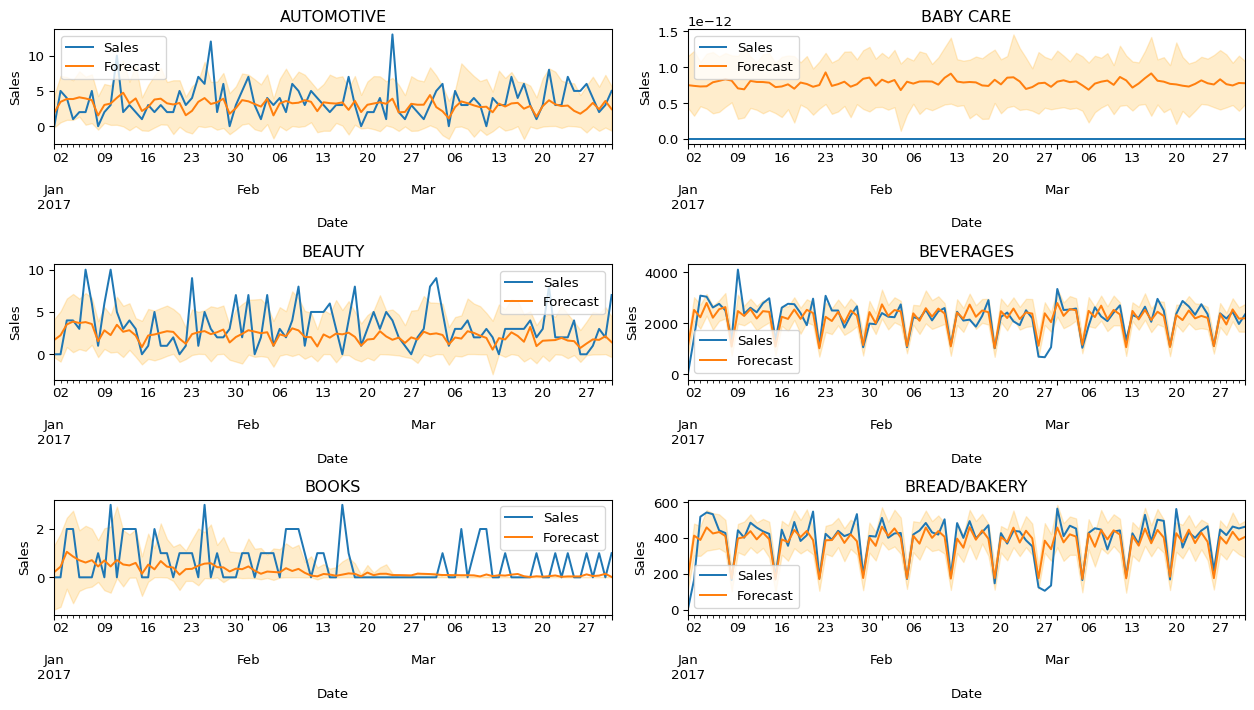

In [19]:

fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()
for ax_ ,family in enumerate(all_preds['family'].unique()[:6]):
    p_ = all_preds.loc[all_preds['family'] == family]
    p_.plot(x='date', y='sales', ax=ax[ax_], label='Sales')
    p_.plot(x='date', y='pred', ax=ax[ax_], label='Forecast')
    ax[ax_].fill_between(p_['date'].values, p_['p10'], p_['p90'], alpha=0.2, color='orange')
    ax[ax_].set_title(family)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Sales')
fig.tight_layout()